# Segmented RF

In [1]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_gcloudaccess"

In [2]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')

source('load_prep_data_expiry.R')


# Identify major registrar with poor performance for head to head

In [3]:
joint_pred_df <- read.csv("../../data/joint_pred_df.csv")
head(joint_pred_df)

,reg,obs_count_s,na_count_s,TP_s,TN_s,P_s,N_s,acc_0.5_s,tpr_0.5_s,tnr_0.5_s,⋯,N_r,acc_0.5_r,tpr_0.5_r,tnr_0.5_r,fpr_0.5_r,fnr_0.5_r,auc_r,aucpr_r,aucpr_srrat,acc_srrat
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 internet,2321,6,460,863,1000,1315,0.5714903,0.46000000,0.6562738,⋯,1318,0.5691512,0.23030907,0.8270106,0.17298938,0.7696909,0.5654244,0.4847203,1.0043963,1.0041097
2,101 domain,32,6,14,6,16,10,0.7692308,0.87500000,0.6000000,⋯,13,0.6562500,1.00000000,0.1538462,0.84615385,0.0000000,0.6923077,0.8021654,0.8717474,1.1721612
3,10dencehispahard,165,2,2,128,31,132,0.7975460,0.06451613,0.9696970,⋯,134,0.8060606,0.03225806,0.9850746,0.01492537,0.9677419,0.7087145,0.3286169,1.0619508,0.9894368
4,1api,190,8,56,45,79,103,0.5549451,0.70886076,0.4368932,⋯,106,0.4789474,0.25000000,0.6603774,0.33962264,0.7500000,0.4977538,0.4620861,1.0168691,1.1586765
5,22net inc,51,0,2,49,2,49,1.0000000,1.00000000,1.0000000,⋯,49,1.0000000,1.00000000,1.0000000,0.00000000,0.0000000,1.0000000,1.0000000,1.0000000,1.0000000
6,ab name isp,15,3,7,0,7,5,0.5833333,1.00000000,0.0000000,⋯,6,0.5333333,0.77777778,0.1666667,0.83333333,0.2222222,0.3888889,0.5754147,1.2661675,1.0937500


In [5]:
# by accuracy
joint_pred_df[c("reg","obs_count_s","na_count_s","acc_0.5_s","acc_0.5_r","acc_srrat")] %>% arrange(desc(obs_count_s))

reg,obs_count_s,na_count_s,acc_0.5_s,acc_0.5_r,acc_srrat
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
namecheap,55117,0,0.9392746,0.9386578,1.0006572
gmo,31494,8,0.9569015,0.9577380,0.9991266
alibaba,30567,1,0.9654191,0.9656492,0.9997617
go daddy,27537,0,0.8560482,0.8553946,1.0007642
pdr ltd,16402,473,0.8698600,0.8735520,0.9957736
reg.ru,15373,1,0.9514702,0.9514083,1.0000651
chengdu west,14040,1,0.9749270,0.9745726,1.0003636
gandi sas,11686,2,0.9649093,0.9655143,0.9993734
hostinger,11140,0,0.9300718,0.9300718,1.0000000


In [9]:
# by auc
joint_pred_df[c("reg","obs_count_s","na_count_s","tpr_0.5_s","tpr_0.5_r","aucpr_s","aucpr_r","aucpr_srrat")] %>% arrange(desc(obs_count_s))

reg,obs_count_s,na_count_s,tpr_0.5_s,tpr_0.5_r,aucpr_s,aucpr_r,aucpr_srrat
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
namecheap,55117,0,0.006009615,0.063401442,0.20315002,0.18892813,1.0752767
gmo,31494,8,0.141703377,0.030036630,0.38607414,0.11609370,3.3255390
alibaba,30567,1,0.001913876,0.003827751,0.16570439,0.17257293,0.9601992
go daddy,27537,0,0.095415118,0.065923172,0.35813266,0.33671268,1.0636150
pdr ltd,16402,473,0.153734940,0.017274472,0.40277116,0.27120713,1.4851053
reg.ru,15373,1,0.001340483,0.000000000,0.18745978,0.14659013,1.2788022
chengdu west,14040,1,0.022471910,0.011204482,0.27039679,0.22024362,1.2277168
gandi sas,11686,2,0.060975610,0.051094891,0.33287310,0.34864064,0.9547742
hostinger,11140,0,0.000000000,0.000000000,0.10372553,0.08330299,1.2451598


# Rf for one registrar of choice

In [15]:
reg_name = 'gmo'

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

[1] 1188250      12

[1] 296797     12

[1] 126254     12

[1] 31494    12

[1] 0.1062521 1.0000000

[1] 0.1061129 1.0000000

In [16]:
# train & test RF


ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)
toc()







# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



In [17]:
auc_ranger_03_reg

[1] 0.9458974

# Seg_GLM for one registrar of choice

In [23]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [24]:
reg_name = 'gmo'

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



[1] 296797     40

[1] 31494    40

[1] 0.1061129 1.0000000

In [25]:
seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [26]:
auc_seg_glm_expiry_exptest_reg

[1] 0.8876557

In [28]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
0.04334159 0.95665841 

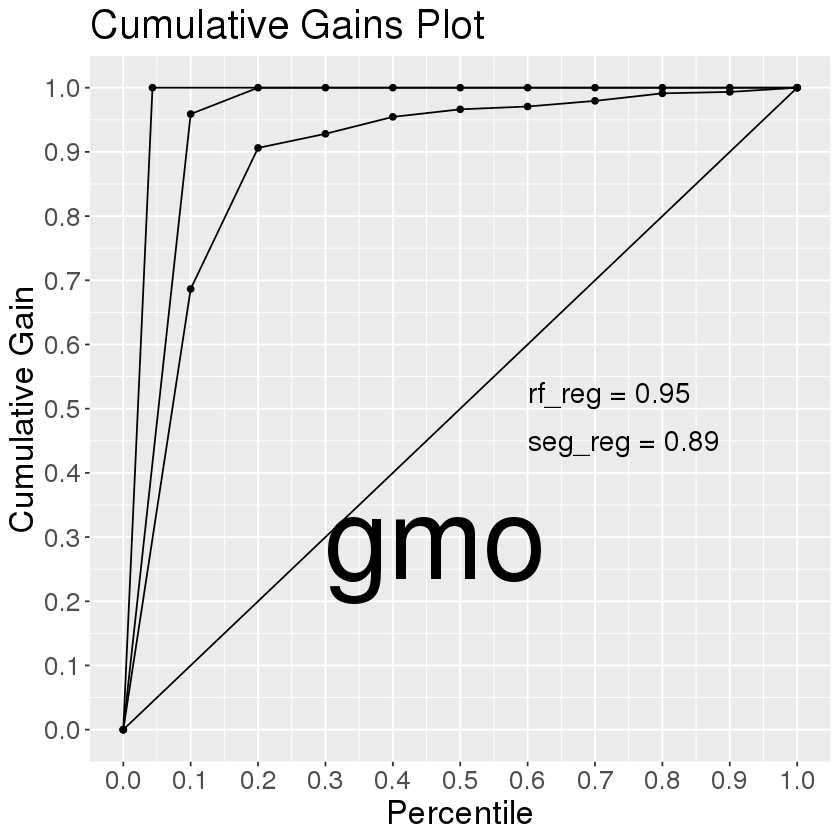

In [35]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = 0.04334159)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .3, y = .3, hjust = 0, label=reg_name,s ize = 24))
# dev.off()

# Another One!

In [36]:
reg_name='namecheap'

In [37]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 221470     12

[1] 55117    12

[1] 0.1863833 1.0000000

[1] 0.1857061 1.0000000

In [38]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 55117    40

[1] 0.1857061 1.0000000

In [39]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
0.06038064 0.93961936 

In [42]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.06038064

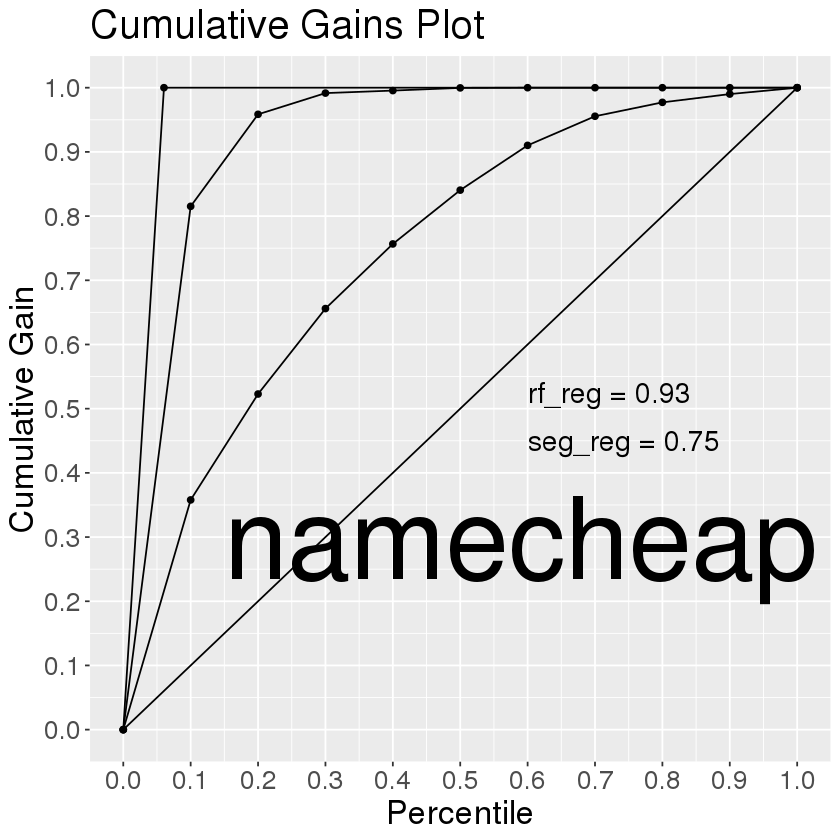

In [45]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Uno Mas!

In [46]:
reg_name='alibaba'

In [47]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 123060     12

[1] 30567    12

[1] 0.1035641 1.0000000

[1] 0.1029896 1.0000000

In [48]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 30567    40

[1] 0.1029896 1.0000000

In [49]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
 0.0341872  0.9658128 

In [50]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.0341872

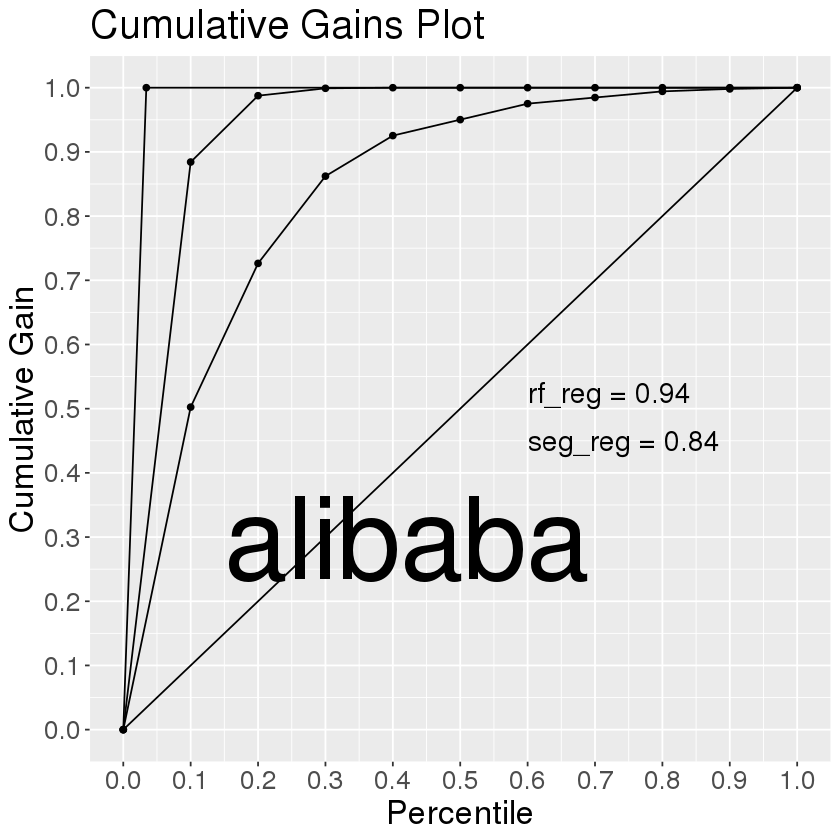

In [51]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# And then? No and then!

In [52]:
reg_name='go daddy'

In [53]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 108988     12

[1] 27537    12

[1] 0.09172144 1.00000000

[1] 0.09278059 1.00000000

In [54]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 27537    40

[1] 0.09278059 1.00000000

In [55]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
 0.1465301  0.8534699 

In [56]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.1465301

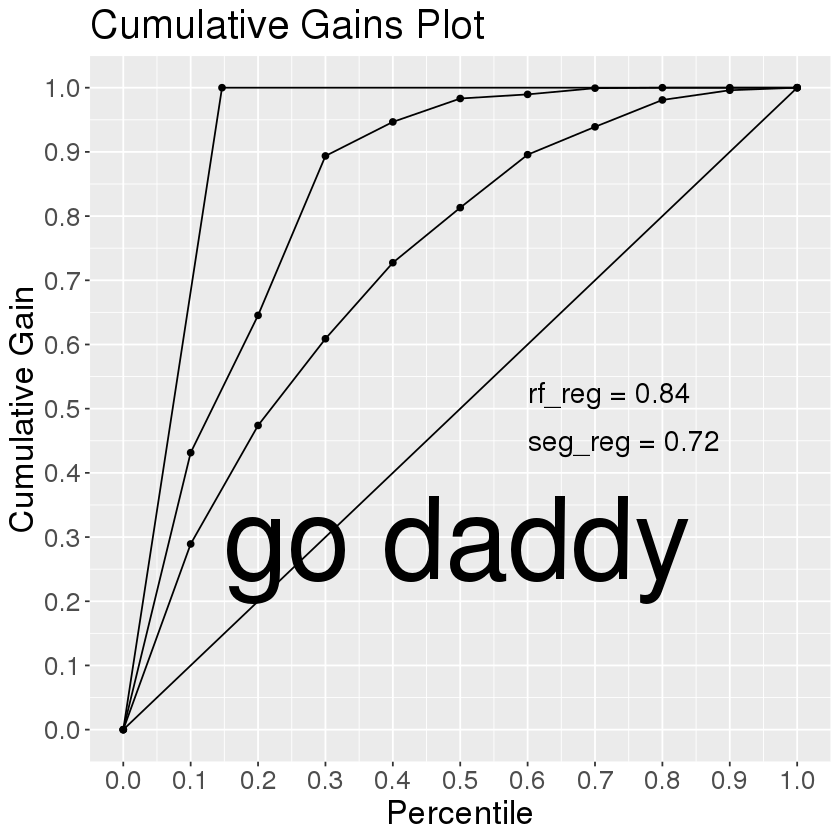

In [57]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()